Can two bart models be used in the same model

In [1]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines

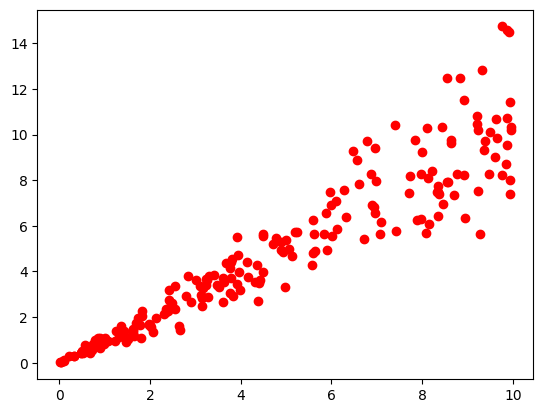

In [319]:
# x = np.tile(np.arange(0,10,1),4)
N = 200
x = np.random.uniform(0,10,N)
e = x/5
y = np.random.normal(x,e)
# e = x*np.random.uniform(-0.3,0.3,size=x.shape[0])+0.01
# y = x + e
# print(x)
# print(e)
# y = y.reshape(y.shape[0],1)
x = x.reshape(x.shape[0],1)

plt.plot(x,y,"ro")
# np.random.uniform(size=10)

In [87]:
print(x.shape)
print(y.shape)

(40, 1)
(40,)


In [279]:
with pm.Model() as mod:
    x_data = pm.MutableData("x_data", x, dims=["obs","var"])
    # print(x_data.shape)
    f = pmb.BART("f", X=x_data, Y = y, m = 20, dims=["obs"])
    sd = pm.HalfNormal("sd")
    # print(f.shape)
    yb = pm.Normal("yb", mu = f, sigma = sd, observed=y, shape = f.shape, dims="obs")
    out = pm.sample(compute_convergence_checks=False, random_seed=1, cores=4, draws=500)
    out.extend(pm.sample_posterior_predictive(trace=out))

pm.model_to_graphviz(mod)
out

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [f]
>NUTS: [sd]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 14 seconds.
Sampling: [yb]


Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

In [280]:
# get stats
f_mean = out.posterior["f"].mean(dim=["chain","draw"])
f_hdi = az.hdi(ary = out, group="posterior", var_names=["f"])
pp = az.extract(out, group="posterior_predictive", var_names="yb").T
idx = np.argsort(x[:, 0])

/home/twj8/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


array([[<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

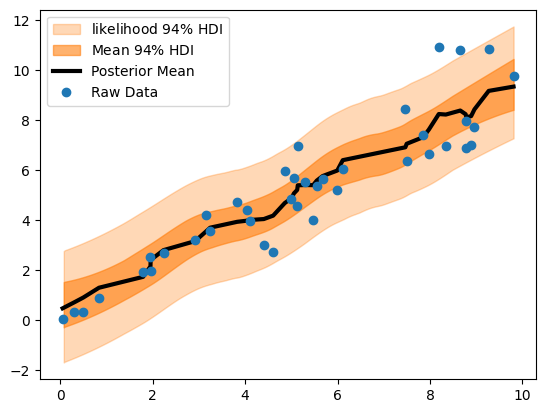

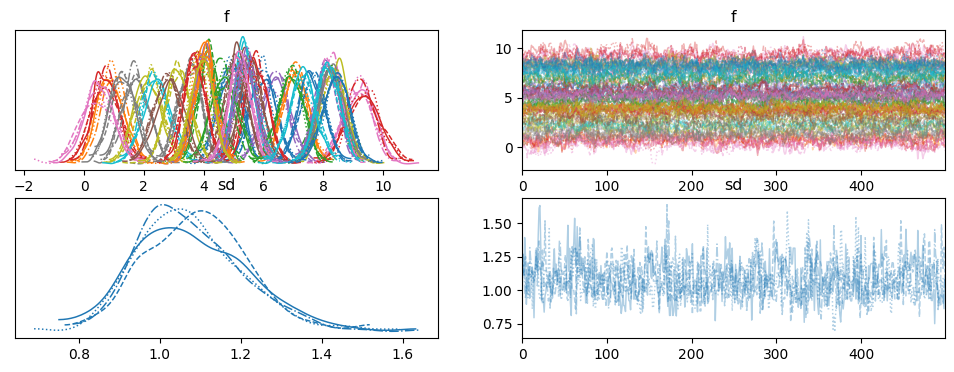

In [281]:
fig, ax = plt.subplots()
az.plot_hdi(x=x[:,0], y=pp, ax=ax, fill_kwargs={"alpha": 0.3, "label":r"likelihood $94\%$ HDI"})
az.plot_hdi(x=x[:, 0], hdi_data=f_hdi["f"], ax=ax, fill_kwargs={"alpha": 0.6, "label": r"Mean $94\%$ HDI"})
ax.plot(x[:, 0][idx], f_mean[idx], c="black", lw=3, label="Posterior Mean")
ax.plot(x, y, "o", c="C0", label="Raw Data")
ax.legend(loc="upper left")
# ax.set(
#     title="Sales as a function of Youtube budget - Posterior Predictive",
#     xlabel="budget",
#     ylabel="sales",
# );

az.plot_trace(out)

Hetero Example

Try with a dimensioned sd

In [238]:
idx
print(x.reshape(40,))
print(e)

[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6
 7 8 9]
[ 0.         -0.22766756 -0.54569234  0.26557143 -1.09572728 -0.70214256
  0.13655035 -1.32575846 -1.27910558 -1.83340265  0.         -0.21625515
  0.59561527  0.09993936  0.40386708  1.19156106 -0.33281674 -0.55255504
  1.52849695 -0.36778561  0.         -0.0332825   0.59785957 -0.23714572
  0.60315247 -0.25419617  1.46034095 -1.310663   -2.08402462  1.36778467
 -0.         -0.23550995 -0.30642125  0.32312036 -0.71496164  0.8971231
 -1.58162095  1.04776236  1.26115322  0.88177854]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>PGBART: [f]
>NUTS: [sd]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 19 seconds.
Sampling: [yb]


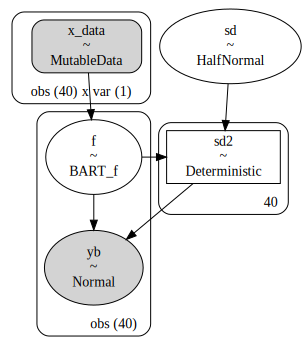

In [282]:
with pm.Model() as mod:
    x_data = pm.MutableData("x_data", x, dims=["obs","var"])
    
    f = pmb.BART("f", X=x_data, Y = y, m = 20, dims=["obs"])
    sd = pm.HalfNormal("sd", sigma= .3)
    sd2 = pm.Deterministic("sd2", abs(sd*f))
    # sd2 = abs(sd*f)
    # print(sd2.shape)
    # print(f.shape)
    yb = pm.Normal("yb", mu = f, sigma = sd2, observed=y, shape = f.shape, dims="obs")
    out = pm.sample(compute_convergence_checks=False, random_seed=1, cores=4, draws=500)
    out.extend(pm.sample_posterior_predictive(trace=out))

pm.model_to_graphviz(mod)


array([[<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>],
       [<AxesSubplot:title={'center':'sd2'}>,
        <AxesSubplot:title={'center':'sd2'}>]], dtype=object)

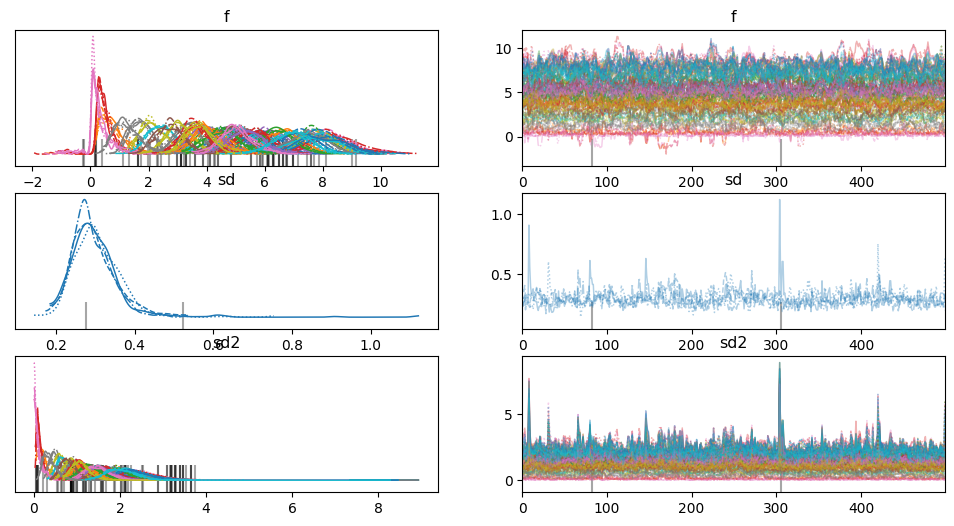

In [283]:
az.plot_trace(out)

In [284]:
# get stats
f_mean = out.posterior["f"].mean(dim=["chain","draw"])
f_hdi = az.hdi(ary = out, group="posterior", var_names=["f"])
pp = az.extract(out, group="posterior_predictive", var_names="yb").T
idx = np.argsort(x[:, 0])

/home/twj8/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


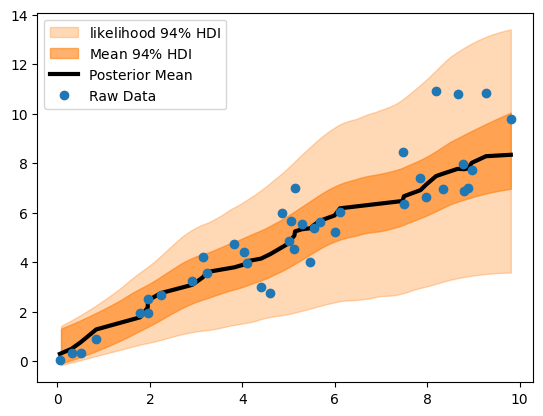

In [285]:
fig, ax = plt.subplots()
az.plot_hdi(x=x[:,0], y=pp, ax=ax, fill_kwargs={"alpha": 0.3, "label":r"likelihood $94\%$ HDI"})
az.plot_hdi(x=x[:, 0], hdi_data=f_hdi["f"], ax=ax, fill_kwargs={"alpha": 0.6, "label": r"Mean $94\%$ HDI"})
ax.plot(x[:, 0][idx], f_mean[idx], c="black", lw=3, label="Posterior Mean")
ax.plot(x, y, "o", c="C0", label="Raw Data")
ax.legend(loc="upper left")
# ax.set(
#     title="Sales as a function of Youtube budget - Posterior Predictive",
#     xlabel="budget",
#     ylabel="sales",
# );



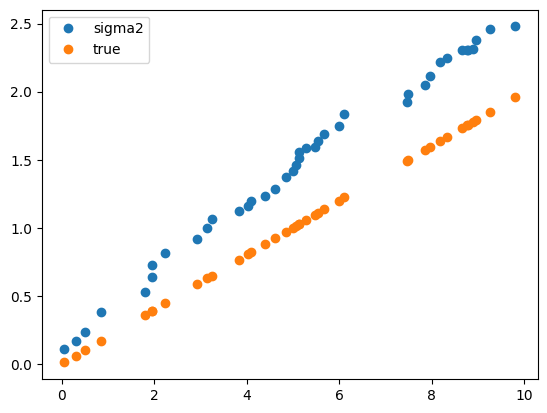

In [286]:
er = out.posterior["sd"].mean(["chain","draw"])
er2 = out.posterior["sd2"].mean(["chain","draw"])

# print(er)
# print(er[idx])
# idx
# er[idx].values.shape
# plt.plot(x[:,0], er.values, "o", label="sigma")
plt.plot(x[:,0], er2, "o", label="sigma2")
plt.plot(x[:,0], e, "o", label="true")
plt.legend()

In [258]:
out.posterior.sd2.mean(["chain","draw"]).values.reshape(4,10).T

array([[0.07236111, 0.07236111, 0.07236111, 0.07236111],
       [0.46896221, 0.46896221, 0.46896221, 0.46896221],
       [0.77185246, 0.77185246, 0.77185246, 0.77185246],
       [1.0798367 , 1.0798367 , 1.0798367 , 1.0798367 ],
       [1.52945946, 1.52945946, 1.52945946, 1.52945946],
       [1.79351833, 1.79351833, 1.79351833, 1.79351833],
       [1.99065917, 1.99065917, 1.99065917, 1.99065917],
       [2.29761902, 2.29761902, 2.29761902, 2.29761902],
       [2.7131056 , 2.7131056 , 2.7131056 , 2.7131056 ],
       [3.03187985, 3.03187985, 3.03187985, 3.03187985]])

In [255]:
e.reshape(4,10).T
print(e)

[ 0.01       -0.0311728  -0.23577688 -0.14203807  0.50019962 -1.23066331
 -1.70601189 -1.82102931  1.88114643  1.29633226  0.01       -0.18960487
 -0.44329367 -0.74304966 -0.46322379 -0.33050827 -0.95517816  0.97790754
 -1.05767628  0.46642963  0.01        0.27331693 -0.5454872   0.21935649
  0.64619266  1.38819441 -1.32253621 -2.05404031 -1.30612084 -1.22319127
  0.01        0.1502286   0.46870922 -0.36452172  0.99462341  0.46961701
  0.36480594 -0.54082775  0.9357172  -0.54776398]


# Heteroskedatic BART

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [f]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 23 seconds.
Sampling: [yb]


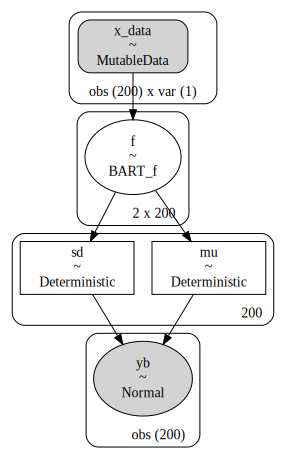

In [322]:
n_obs = x.shape[0]
with pm.Model() as mod:
    x_data = pm.MutableData("x_data", x, dims=["obs","var"])
    
    f = pmb.BART("f", X=x_data, Y = y, m = 20, shape=(2,n_obs))
    mu = pm.Deterministic("mu", f[0])
    sd = pm.Deterministic("sd", np.exp(f[1]))
    yb = pm.Normal("yb", mu = mu, sigma = sd, observed=y, dims="obs")
    out = pm.sample(compute_convergence_checks=False, random_seed=1, cores=4, draws=500)
    out.extend(pm.sample_posterior_predictive(trace=out))

pm.model_to_graphviz(mod)


array([[<AxesSubplot:title={'center':'f'}>,
        <AxesSubplot:title={'center':'f'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sd'}>,
        <AxesSubplot:title={'center':'sd'}>]], dtype=object)

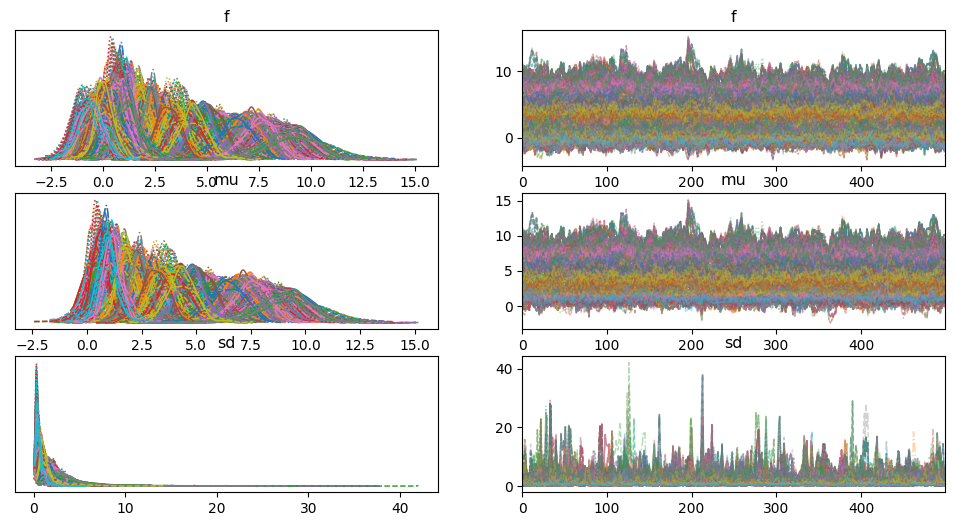

In [323]:
az.plot_trace(out)

In [392]:
# dir(f.owner.op.all_trees[0])
print(dir(f.owner.op.all_trees[0][0][0])[-20:])
dir(f.owner.op.all_trees)[-20:]

['__setitem__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_predict', '_traverse_leaf_values', '_traverse_tree', 'copy', 'get_node', 'get_split_variables', 'grow_leaf_node', 'idx_leaf_nodes', 'new_tree', 'output', 'predict', 'set_node', 'split_rules', 'tree_structure', 'trim']


['_exposed_',
 '_getvalue',
 '_id',
 '_idset',
 '_incref',
 '_manager',
 '_mutex',
 '_owned_by_manager',
 '_serializer',
 '_tls',
 '_token',
 'append',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [324]:
out.posterior["f"].mean(("draw", "chain"))

<xarray.DataArray 'f' (f_dim_0: 2, f_dim_1: 200)>
array([[ 7.00779453e+00,  3.02532543e+00,  1.11330168e+00,
         2.69200763e+00,  7.66052277e+00,  7.11834979e-01,
         6.64524742e+00,  1.33989665e+00,  2.59055216e+00,
         4.09717275e+00,  4.03753353e+00,  8.98537599e+00,
         3.22018625e-01,  1.25563042e+00,  8.29550536e+00,
         4.56547557e+00,  2.99203620e+00,  6.01824645e-01,
         8.61499533e+00,  8.91875943e+00,  7.86578518e+00,
         3.78816648e-01,  8.89984985e+00,  7.20882003e+00,
         2.89139786e+00,  5.94234539e+00,  3.41774427e+00,
         5.33822665e+00,  6.43287776e+00,  6.47614364e+00,
         4.36404402e+00,  2.11750947e+00,  4.49903255e+00,
         5.13750134e+00,  7.77944418e+00,  2.65666202e+00,
         1.45145826e+00,  7.71190584e+00,  3.07172013e+00,
         8.23843320e+00,  8.80283930e+00,  7.63566888e-01,
         8.66548141e+00,  8.15679039e+00,  1.54410040e+00,
         5.40256769e+00,  5.21318785e+00,  2.16925430e+00,
         1.69436199e+00,  3.27122244e+00,  6.17230102e+00,
         8.25407553e+00,  8.48316524e+00,  3.24680791e-01,
         6.02502467e+00,  8.53327854e+00,  2.36011213e+00,
         6.08923601e+00,  8.43893873e+00,  3.88297428e+00,
...
        -5.17690511e-01,  5.99485918e-02,  3.18884325e-01,
         6.57673811e-01,  1.08468432e+00, -7.46846020e-01,
         9.35363706e-01, -1.95734297e-02,  3.03751378e-01,
         6.07287686e-01,  5.68970781e-01, -3.61056527e-01,
        -7.50304008e-01, -5.83534121e-01,  7.09119870e-01,
         4.39117617e-01, -3.57826546e-01,  1.53289779e-01,
        -7.95182352e-01,  3.01684649e-01, -1.85083933e-01,
         4.37978176e-01,  8.70686347e-01, -5.42871454e-01,
         1.21084723e-01,  6.99148773e-01,  9.84643704e-02,
        -3.36283013e-01, -2.51827890e-01, -6.68263678e-01,
        -3.40704773e-01,  7.00839021e-01, -7.91919269e-01,
         8.46423805e-01, -2.70626474e-01,  1.01584830e+00,
         7.19057393e-01, -3.74752497e-01,  8.86935257e-02,
         1.19154624e+00,  6.23969207e-01,  2.98140909e-01,
         1.10220125e-01,  6.87319534e-01,  3.35635585e-01,
         7.53991565e-01, -2.13968733e-01,  2.03665054e-02,
        -6.52780373e-01,  5.72150920e-01, -5.45869639e-02,
         1.17369612e+00, -6.69202507e-01,  2.78154168e-01,
        -4.16734549e-02, -5.49955145e-01,  1.20660799e+00,
         2.26156076e-01, -6.74527180e-01]])
Coordinates:
  * f_dim_0  (f_dim_0) int64 0 1
  * f_dim_1  (f_dim_1) int64 0 1 2 3 4 5 6 7 ... 192 193 194 195 196 197 198 199

In [325]:
# get stats
f_mean = out.posterior["f"].mean(dim=["chain","draw"])[0]
f_hdi = az.hdi(ary = out, group="posterior", var_names=["f"])
pp = az.extract(out, group="posterior_predictive", var_names="yb").T
idx = np.argsort(x[:, 0])


/home/twj8/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


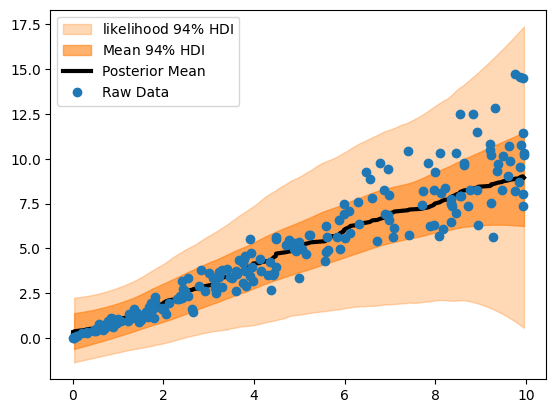

In [326]:
fig, ax = plt.subplots()
az.plot_hdi(x=x[:,0], y=pp, ax=ax, fill_kwargs={"alpha": 0.3, "label":r"likelihood $94\%$ HDI"})
az.plot_hdi(x=x[:,0], hdi_data=f_hdi["f"][0], ax=ax, fill_kwargs={"alpha": 0.6, "label": r"Mean $94\%$ HDI"})
ax.plot(x[:, 0][idx], f_mean[idx], c="black", lw=3, label="Posterior Mean")
ax.plot(x, y, "o", c="C0", label="Raw Data")
ax.legend(loc="upper left")

In [334]:
e.mean()
out.posterior["sd"].mean(["chain","draw"]).mean()

<xarray.DataArray 'sd' ()>
array(1.72641944)

In [393]:
type(out, o)

arviz.data.inference_data.InferenceData